In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
 !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

In [11]:
from fastbook import *
from fastai.vision.widgets import *

In [31]:
key = os.environ.get('AZURE_SEARCH_KEY', '1b108a98eb0b4354aa1331fbfb4efbbf')

In [77]:
print (key)
search_images_bing

1b108a98eb0b4354aa1331fbfb4efbbf


<function __main__.search_images_bing(key, term, max_images: int = 100, **kwargs)>

In [94]:
results = search_images_bing(key, 'Lord Bramha')
ims = results.attrgot('contentUrl')
len(ims)

100

In [91]:
#hide
#ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [95]:
dest = 'images/lordbramha.jpg'
download_url(ims[0], dest)

Path('images/lordbramha.jpg')

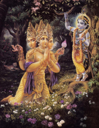

In [105]:
im = Image.open(dest)
im.to_thumb(128,128)

In [120]:
bear_types = 'LordBramha','LordVishnu','Lordmahesh'
path = Path('Lord')

In [121]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} God')
        download_images(dest, urls=results.attrgot('contentUrl'))
        print (path)

Lord
Lord
Lord


In [122]:
fns = get_image_files(path)
fns

(#296) [Path('Lord/LordBramha/dc1a2abc-9844-4990-809c-071a34814605.jpg'),Path('Lord/LordBramha/1619376d-7449-4486-ab7e-21e6d9f4433c.jpg'),Path('Lord/LordBramha/07656c2f-7904-4bc5-b4e6-1fec768742ad.jpg'),Path('Lord/LordBramha/75d83288-52bb-4564-96a5-bdb375bb020f.jpg'),Path('Lord/LordBramha/9d469c3f-ed4c-40bd-b66c-9405627d66d5.jpg'),Path('Lord/LordBramha/294ee96d-9eaa-4a58-ba72-7777f0c6f391.png'),Path('Lord/LordBramha/057f9684-591f-423e-8676-f67b88085ac8.jpg'),Path('Lord/LordBramha/12cd8052-8535-4efd-a476-29de35d4dea8.jpg'),Path('Lord/LordBramha/cdb271b2-6901-45b1-be33-a131fd5ce0a5.jpg'),Path('Lord/LordBramha/a4b474ad-44e7-410d-b9f8-e9af1a6e7fc8.jpg')...]

In [123]:
failed = verify_images(fns)
failed

(#2) [Path('Lord/LordBramha/90f47a6d-8d51-46ff-a419-53684c07cae8.jpg'),Path('Lord/LordVishnu/f7cefd47-47cb-48b6-8077-b58ab6c1322c.jpg')]

In [124]:
failed.map(Path.unlink);

In [125]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [126]:
dls = bears.dataloaders(path)

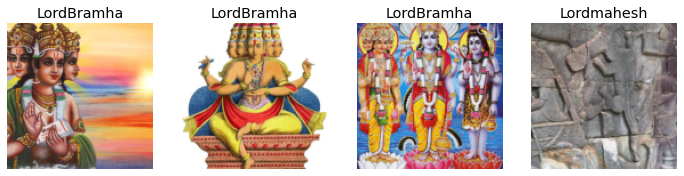

In [127]:
dls.valid.show_batch(max_n=4, nrows=1)

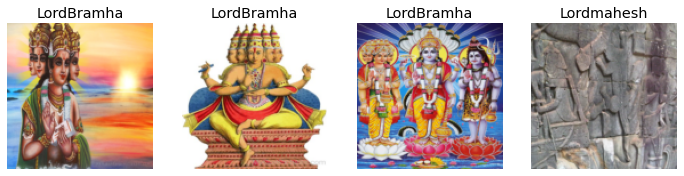

In [128]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

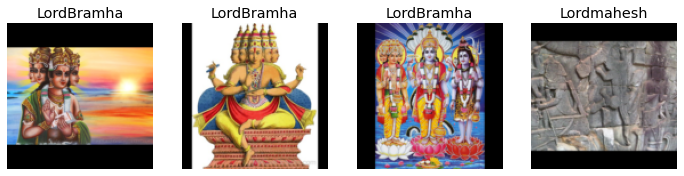

In [129]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

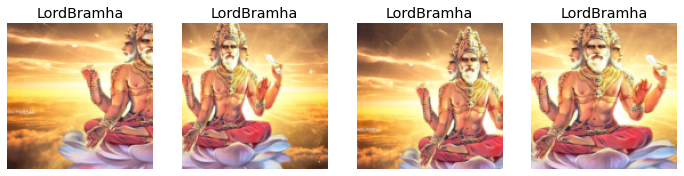

In [130]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

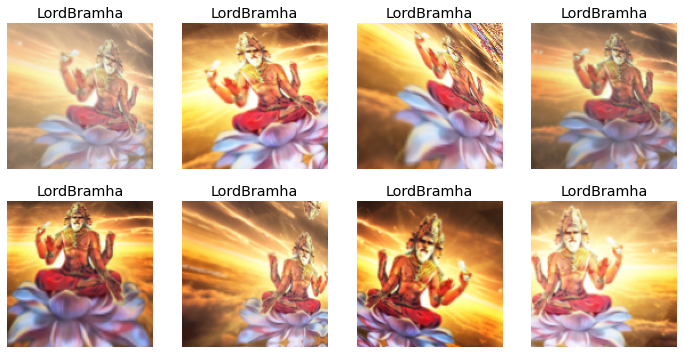

In [131]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [132]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [133]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.757081,2.804383,0.672414,00:34


epoch,train_loss,valid_loss,error_rate,time
0,1.031248,1.217031,0.500000,00:43
1,0.901365,0.583093,0.241379,00:42
2,0.720146,0.291402,0.155172,00:42
3,0.598493,0.234619,0.120690,00:43


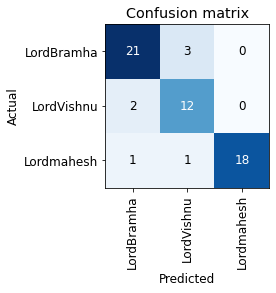

In [135]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

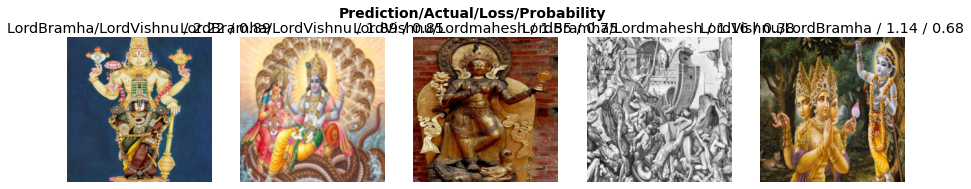

In [136]:
interp.plot_top_losses(5, nrows=1)

In [137]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [138]:
learn.export()

In [56]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [57]:
learn_inf = load_learner(path/'export.pkl')

In [61]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.8489e-06, 1.0000e+00, 1.8099e-06]))

In [62]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']